<div style="text-align: center">
    <img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/logo.png?raw=true' width=800/>  
</div>

# **Sequential Decision Making and Reinforcement Learning (SDRML) Final Project**

## 👥 **Team Members**

### [Almog Anschel](mailto:anschelalmog@campus.technion.ac.il)

### [Eden Hindi](mailto:eden.hindi@campus.technion.ac.il)


## 📌 [GitHub Repo & Paper](https://github.com/anschelalmog/SDRML_project.git)




# <img src="https://img.icons8.com/?size=100&id=ZGqV6cHUtDmj&format=png&color=000000" style="height:50px;display:inline"> Imports and Utillity Functions




## Imports

In [ ]:
from IPython.display import clear_output
!pip install torch gymnasium tensorboardX matplotlib pyyaml stable-baselines3
clear_output()

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import yaml
from datetime import datetime
from enum import Enum
from collections import deque
import pandas as pd
from collections import defaultdict
import itertools
import time
##################
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
##################
import gymnasium as gym
from gymnasium.envs.registration import register
from gymnasium import spaces, utils
###################
import stable_baselines3 as sb3
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy


## Utility Functions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
print("Random seed set.")

hyperparams = {}

gym.envs.register(
    id="ElectricityMarketEnv-v0",
    entry_point="__main__:ElectricityMarketEnv",
    kwargs={"params": hyperparams}
)

def normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    return (array - min_val) / (max_val - min_val)

Using device: cuda
Random seed set.


## Training Functions

In [ ]:
def run_configuration(reward_type, demand_type):
    print(f"\nRunning configuration: Reward={reward_type.value}, Demand={demand_type.value}")

    # Set up configuration-specific hyperparameters
    hyperparams = base_hyperparams.copy()
    hyperparams["reward type"] = reward_type
    hyperparams["demand type"] = demand_type

    # Create the environment
    env = gym.make('ElectricityMarketEnv-v0', params=hyperparams)
    hyperparams["state_dim"] = env.observation_space.shape[0]
    hyperparams["battery_capacity"] = env.unwrapped.battery_capacity
    hyperparams["max_steps_per_episode"] = env.unwrapped.max_steps

    # Create and train the SAC agent
    agent = SACAgent(hyperparams)

    start_time = time.time()
    trainer = Trainer(env, agent, hyperparams)
    reward_history = trainer.train()

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Calculate metrics from the latter part of training (from episode 50 onward)
    latter_rewards = reward_history[50:]
    avg_reward_latter = np.mean(latter_rewards)
    std_reward_latter = np.std(latter_rewards)

    print(f"Performance (eps 50+): Avg reward = {avg_reward_latter:.2f} ± {std_reward_latter:.2f}")

    # Evaluate the agent
    eval_rewards = []
    for i in range(eval_episodes):
        state, _ = env.reset(seed=i+2000)
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state, evaluate=True)
            action = np.array([action], dtype=np.float32)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state

        eval_rewards.append(total_reward)

    avg_reward_eval = np.mean(eval_rewards)
    std_reward_eval = np.std(eval_rewards)

    print(f"Evaluation: Avg reward = {avg_reward_eval:.2f} ± {std_reward_eval:.2f}")

    # Close the writer to free resources
    agent.close()

    # Create a more detailed results structure
    result_data = {
        'agent': 'SAC',
        'reward_type': reward_type.value,
        'demand_type': demand_type.value,
        'avg_reward_latter': avg_reward_latter,
        'std_reward_latter': std_reward_latter,
        'avg_reward_eval': avg_reward_eval,
        'std_reward_eval': std_reward_eval,
        'training_time': training_time,
        'final_entropy': agent.alpha if hasattr(agent, 'alpha') else None,
        'agent_instance': agent,
        'env': env
    }

    return result_data, reward_history

def evaluate(agent, env, n_episodes=10):
  """
  Evaluate the agent's performance without exploration.

  Args:
      agent: The agent to evaluate
      env: The environment to evaluate in
      n_episodes: Number of episodes to evaluate

  Returns:
      avg_reward: Average reward per episode
  """
  all_rewards = []

  for ep in range(n_episodes):
      state, _ = env.reset(seed=ep+1000)  # Different seeds from training
      done = False
      total_reward = 0

      while not done:
          action = agent.select_action(state, evaluate=True)  # Use deterministic policy
          action = np.array([action], dtype=np.float32)
          next_state, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated

          total_reward += reward
          state = next_state

      all_rewards.append(total_reward)
      print(f"Evaluation episode {ep+1}/{n_episodes} - Reward: {total_reward:.2f}")

  avg_reward = np.mean(all_rewards)
  print(f"Average evaluation reward: {avg_reward:.2f}")
  return avg_reward

## Plot Functions

In [ ]:
def visualize_best_episode():
    """
    Run and visualize a single episode using the best trained agent.
    """
    # Get the best configuration
    best_config = results_df.loc[results_df['Avg Reward (Eps 50+)'].idxmax()]['Configuration']
    result = results[best_config]

    # Get the agent and environment
    agent = result['agent_instance']
    env = result['env']

    state, _ = env.reset(seed=42)  # Use a fixed seed for visualization
    done = False

    # Initialize lists to store data
    states = []
    actions = []
    rewards = []

    while not done:
        states.append(state)
        action = agent.select_action(state, evaluate=True)
        action = np.array([action], dtype=np.float32)
        actions.append(action[0])

        next_state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)

        done = terminated or truncated
        state = next_state

    # Convert to numpy arrays for easier slicing
    states = np.array(states)
    actions = np.array(actions)

    # Create figure with 4 subplots
    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    # Plot SOC
    axs[0].plot(states[:, 0], label='Battery SoC')
    axs[0].set_ylabel('State of Charge')
    axs[0].set_title(f'Battery State of Charge Over Time (Best Config: {best_config})')
    axs[0].legend()
    axs[0].grid(True)

    # Plot demand
    axs[1].plot(states[:, 1], label='Electricity Demand', color='green')
    axs[1].set_ylabel('Demand')
    axs[1].set_title('Household Electricity Demand Over Time')
    axs[1].legend()
    axs[1].grid(True)

    # Plot price
    axs[2].plot(states[:, 2], label='Electricity Price', color='red')
    axs[2].set_ylabel('Price')
    axs[2].set_title('Electricity Market Price Over Time')
    axs[2].legend()
    axs[2].grid(True)

    # Plot actions
    axs[3].plot(actions, label='Agent Actions', color='purple')
    axs[3].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axs[3].set_ylabel('Action (+ charge, - discharge)')
    axs[3].set_xlabel('Time Step')
    axs[3].set_title('Agent Actions Over Time')
    axs[3].legend()
    axs[3].grid(True)

    plt.tight_layout()
    plt.savefig('best_config_episode.png')
    plt.show()

# <img src="https://img.icons8.com/?size=100&id=ZKacxH3j7_2b&format=png&color=000000" style="height:50px;display:inline"> Environment

The **ElectricityMarketEnv** is an environment for simulating an electricity market with a battery storage system.

The agent interacts with the environment by taking continuous actions, charging (positive) or discharging (negative) a battery.

The environment models the dynamics of household electricity demand and market price, both following periodic functions with noise.

---

## **States**
- **$SoC$** : State of Charge - current energy level in the battery.
- **$ D_t$**: Household electricity demand at the current timestep.
- **$ P_t$**: Market price of electricity at the current timestep.


## **Action**
- **$A$** A continuous value in **$[- \text{battery_cap}, \text{battery_cap}]$**, the amount of charging/discharing  the battery.



## **Reward:**
We will experiment with two reward functions, each with different intentions:
1. **Profit:** (default) $R = P_t \times \text{sold_energy}$
- Rewards the agent solely based on the revenue generated from selling surplus energy after meeting demand.
2. **Internal Demanad:** $R = P_t \times \text{discharge_amount} - \lambda \times \max(0, D_t - \text{discharge_amount})$
- This encourages the agent to prioritize internal demand before selling energy.

In [ ]:
class RewardType(Enum):
    PROFIT = "profit"
    INTERNAL_DEMAND = "internal"

## **Demand function and Price function:**
### Demand Function
We will experiment with 3 demand function:
1. **Mixsture of Gaussians:**
 As in the example, model the demand by two overlapping Gaussian distributions
2. **Sinusaidl functions:** This implements a combination of sine waves with different frequencies and amplitudes, epresent the natural cyclic behavior of electricity.
3. **Two Step function:** The simplest model uses discrete jumps in demand at specific time intervals. Demand is zero except during two time windows.

### Price function
This implementation establishes a linear relationship where price increases proportionally with demand, to create a realistic simulation of electricity market dynamics.

In [ ]:
class DemandType(Enum):
    GAUSSIAN = "gaussian"
    SINUSOIDAL = "sinusoidal"
    STEP = "step"

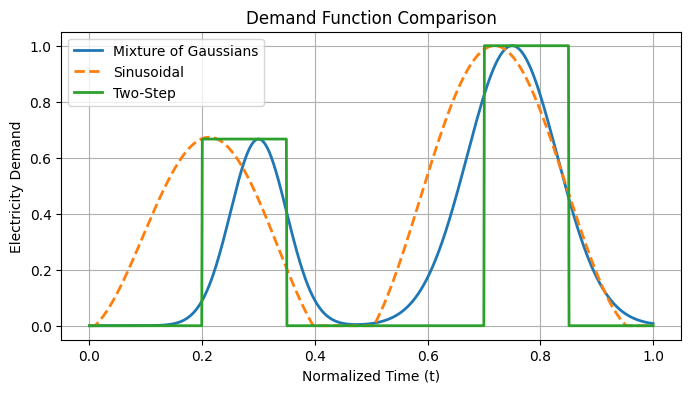

(<matplotlib.legend.Legend at 0x7ccb1ad5d010>, None, None)

In [ ]:
t_values = np.linspace(0, 1, 1000)
gaussian = 80 * np.exp(-((t_values - 0.3) ** 2) / (2 * 0.05**2)) + 120 * np.exp(-((t_values - 0.75) ** 2) / (2 * 0.08**2))
sinusoidal = np.flip(np.maximum(80 * np.sin(4 * np.pi * t_values-2) + 30 * np.sin(2 * np.pi * t_values) + 70, 0))
step = np.where((0.2 <= t_values) & (t_values < 0.35), 100, 0) + np.where((0.7 <= t_values) & (t_values < 0.85), 150, 0)

gaussian = normalize(gaussian)
sinusoidal = normalize(sinusoidal)
step = normalize(step)

plt.figure(figsize=(8, 4))
plt.plot(t_values, gaussian, '-', label="Mixture of Gaussians", linewidth=2)
plt.plot(t_values, sinusoidal, '--', label="Sinusoidal", linewidth=2)
plt.plot(t_values, step, '-', label="Two-Step", linewidth=2)
plt.xlabel("Normalized Time (t)"), plt.ylabel("Electricity Demand"), plt.title("Demand Function Comparison")
plt.legend(), plt.grid(), plt.show()

## Enviorment Implemantion

In [ ]:
class ElectricityMarketEnv(gym.Env):
    def __init__(self, **kwargs):
        super(ElectricityMarketEnv, self).__init__()

        params = kwargs.get("params", {})

        # Battery parameters
        self.battery_capacity = params.get("battery_capacity", 100)
        assert self.battery_capacity > 0, "Battery capacity must be positive."
        self.initial_soc = params.get("initial_soc", 50)
        assert self.initial_soc <= self.battery_capacity, f"Initial SoC {self.initial_soc} exceeds battery capacity {self.battery_capacity}."
        self.soc = self.initial_soc  # Current SoC

        # Environment dynamics parameters
        self.max_steps = params.get("max_steps", 200)  # Total timesteps in one episode
        self.current_step = 0

        # action space
        self.action_space = spaces.Box(low=-self.battery_capacity,
                                     high=self.battery_capacity,
                                     shape=(1,),
                                     dtype=np.float32)

        # state space: [SoC, Demand, Price] all dimensions are continuous.
        obs_low = np.array([0.0, 0.0, 0.0], dtype=np.float32)
        obs_high = np.array([self.battery_capacity, np.finfo(np.float32).max, np.finfo(np.float32).max],
                          dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        self.reward_type = params.get("reward type", RewardType.PROFIT)
        assert self.reward_type in RewardType, f"Invalid reward type."
        self.demand_type = params.get("demand type", DemandType.GAUSSIAN)
        assert self.demand_type in DemandType, f"Invalid demand type."

        self.seed()

    def seed(self, seed=None):
        """
        Set the seed for random number generation.
        """
        self.np_random, seed = utils.seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None, options=None):
        """
        Reset the environment to the initial state at the start of an episode.
        """
        if seed is not None:
            self.seed(seed)

        self.soc = self.initial_soc
        self.current_step = 0
        obs = self._get_obs()
        return obs, {}

    def _get_obs(self):
        """
        returns current observation.
        The observation includes the [current SoC, demand, price].
        """
        t_norm = self.current_step / self.max_steps  # Normalized time [0, 1]
        demand = self._demand_function(t_norm)
        price = self._price_function(demand, t_norm)

        if isinstance(demand, np.ndarray):
            if demand.size == 1:
                demand = demand.item()
            else:
                demand = float(demand[0])

        if isinstance(price, np.ndarray):
            if price.size == 1:
                price = price.item()
            else:
                price = float(price[0])

        obs = np.array([float(self.soc), float(demand), float(price)], dtype=np.float32)
        return obs

    def _demand_function(self, t):
        """
        Compute the household electricity demand at time t.
        """
        demand = 0.0

        if self.demand_type == DemandType.GAUSSIAN:
            demand = 80 * np.exp(-((t - 0.3) ** 2) / (2 * 0.05**2)) + 120 * np.exp(-((t - 0.75) ** 2) / (2 * 0.08**2))

        elif self.demand_type == DemandType.SINUSOIDAL:
            demand = 80 * np.sin(4 * np.pi * t - 2) + 30 * np.sin(2 * np.pi * t) + 70

        else:  # Demand.STEP
            if 0.2 <= t < 0.35:
                demand = 100
            elif 0.7 <= t < 0.85:
                demand = 150
            else:
                demand = 0

        noise = float(self.np_random.normal(0, 5.0))
        demand = max(float(demand) + noise, 0.0)  # Ensure demand is non-negative and a scalar

        return demand

    def _price_function(self, demand, t):
        """
        Compute the market price of electricity at time t.
        as a linear transformation of the demand.
        """
        if isinstance(demand, np.ndarray):
            if demand.size == 1:
                demand = demand.item()
            else:
                demand = float(demand[0])

        m, b = 0.5, 10.0  # Base price plus demand component
        base_price = m * float(demand) + b
        noise = float(self.np_random.normal(0, 2.0))
        price = max(base_price + noise, 0.0)

        return float(price)  # Ensure returned price is a scalar

    def step(self, action):
        """
        Execute one timestep in the environment.

        Parameters:
            action (array): representing the amount of energy to charge or discharge the battery.

        Returns:
            - obs (array): Next observation ([SoC, demand, price]).
            - reward (float): Reward earned this timestep.
            - terminated (bool): Always `False` in this implementation.
            - truncated (bool): Indicates whether the episode has ended.
            - info (dict): Additional info, empty in this implementation.
        """

        # action within allowed bounds.
        action = np.clip(action, self.action_space.low, self.action_space.high)
        action_value = float(action[0].item())  # Ensure scalar
        info = {}

        # Compute current demand and price based on normalized time.
        t_norm = self.current_step / self.max_steps
        demand = self._demand_function(t_norm)
        price = self._price_function(demand, t_norm)

        # Ensure demand and price are scalar values
        if isinstance(demand, np.ndarray):
            if demand.size == 1:
                demand = demand.item()
            else:
                demand = float(demand[0])

        if isinstance(price, np.ndarray):
            if price.size == 1:
                price = price.item()
            else:
                price = float(price[0])

        if action_value >= 0:
            # Charging the battery.
            charge_amount = min(action_value, self.battery_capacity - self.soc)
            cost = price * charge_amount
            self.soc += charge_amount
            reward = -float(cost)

        else:
            # Discharging the battery.
            discharge_requested = -action_value
            discharge_possible = min(discharge_requested, self.soc)
            self.soc -= discharge_possible

            # Use discharged energy to meet the household demand.
            # Any energy beyond meeting the demand is sold to the grid.
            if discharge_possible >= demand:
                sold_energy = discharge_possible - demand
            else:  # Not enough to cover demand
                sold_energy = 0.0

            # Compute reward
            reward = self._compute_reward(demand, sold_energy, price, discharge_possible)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        truncated = done

        # Construct next observation - ensure all values are scalar
        obs = np.array([float(self.soc), float(demand), float(price)], dtype=np.float32)
        terminated = False

        return obs, float(reward), terminated, truncated, info

    def _compute_reward(self, demand, sold_energy, price, discharge_amount):
        """
        Compute the reward based on the reward type.

        Parameters:
        - demand (float): The household energy demand.
        - sold_energy (float): The amount of energy sold.
        - price (float): The price at which energy is sold.
        - discharge_amount (float): The amount of energy discharged to meet demand.

        Returns:
        - reward (float): The computed reward based on the selected reward function.
        """
        if self.reward_type == RewardType.PROFIT:
            # Fixed: Use just the sold energy for profit calculation
            reward = float(price) * float(sold_energy)

        else:  # RewardType.INTERNAL_DEMAND
            penalty = 10.0
            unmet_demand = max(0.0, float(demand) - float(discharge_amount))
            # Fixed: Balanced reward calculation
            reward = float(price) * float(sold_energy) - penalty * float(unmet_demand)

        return float(reward)

    def render(self, mode='human'):
        """
        Render the current state of the environment.
        """
        print(f"Step: {self.current_step}, SoC: {self.soc:.2f}")

# <img src="https://img.icons8.com/?size=100&id=6MP1kA74ozKg&format=png&color=000000" style="height:50px;display:inline"> **SAC Agent**

The following SACAgent class serves as the coordinator for the Soft Actor-Critic algorithm, a Model-free, off-Policy Algorithm, integrating the Actor and Critic to managing the learning process.

The SAC algorithm optimizes a maximum entropy objective:
$$ J(π)=\mathbb{E}_{\tau \sim \pi}[\sum_{t=0}^{∞}\gamma^t(r(s_t​,a_t​)+\alpha\mathcal{H}(π(⋅\mid s_t​)))] $$
Where:

1. $\tau$ represents trajectories sampled according to policy $\pi$

2. $γ$ is the discount factor (0.99 in your implementation)

3. $r(s_t, a_t)$ is the reward
4. $\alpha$ is the temperature parameter controlling the entropy weight

5. $\mathcal{H}(\pi(\cdot|s_t))$ is the entropy of the policy at state $s_t$

The automatic temperature tuning adjusts $\alpha$
to maintain a target entropy level, using the loss:

$$\mathcal{L}(\alpha) = \mathbb{E}_{a_t \sim \pi_t}[-\alpha \log \pi_t(a_t|s_t) - \alpha \mathcal{H}_{\text{target}}]$$

We used:
1. Twin critics for reducing overestimation bias
2. Soft update: $\theta_\text{target​}\leftarrow \tau \theta+(1−τ)\theta_{target}$​ to constrain updates



In [ ]:
class SACAgent:
    def __init__(self, hyperparams):
        """
        Initialize the Soft Actor-Critic (SAC) agent.

        Args:
            hyperparams (dict): Dictionary containing hyperparameters
        """
        self.state_dim = hyperparams.get("state_dim", 3)
        self.action_dim = 1
        self.max_action = hyperparams.get("battery_capacity", 100.0)

        self.hidden_dim = hyperparams.get("hidden_dim", 256)

        self.gamma = hyperparams.get("gamma", 0.99)
        self.tau = hyperparams.get("tau", 0.005)  # Target network update rate
        self.alpha = hyperparams.get("alpha", 0.2)  # Temperature parameter
        self.automatic_entropy_tuning = hyperparams.get("automatic_entropy_tuning", True)

        self.actor_lr = hyperparams.get("actor_lr", 3e-4)
        self.critic_lr = hyperparams.get("critic_lr", 3e-4)
        self.alpha_lr = hyperparams.get("alpha_lr", 3e-4)

        self.buffer_size = hyperparams.get("replay_capacity", 100000)
        self.batch_size = hyperparams.get("batch_size", 256)
        self.replay_buffer = ReplayBuffer(self.buffer_size)

        self.updates_per_step = hyperparams.get("updates_per_step", 2)

        # Initialize actor and critics
        self.actor = Actor(self.state_dim, self.action_dim, self.hidden_dim, self.max_action).to(device)

        self.critic_1 = Critic(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.critic_2 = Critic(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.critic_1_target = Critic(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.critic_2_target = Critic(self.state_dim, self.action_dim, self.hidden_dim).to(device)

        # Initialize target networks with same weights
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())

        # Optimizers
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=self.critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=self.critic_lr)

        # Automatic entropy tuning
        if self.automatic_entropy_tuning:
            # Target entropy is -|A| (e.g., -1 for single dimension)
            self.target_entropy = -self.action_dim
            # Initialize log_alpha parameter
            self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
            self.alpha = self.log_alpha.exp().item()
            self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=self.alpha_lr)

        self.epsilon = 0.0

        # For logging and visualization
        self.writer = SummaryWriter(f"runs/sac_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
        self.episode_rewards = []
        self.losses = []
        self.total_steps = 0

        self.device = device

    def select_action(self, state, evaluate=False):
        """
        Select an action given the current state.

        Args:
            state : Current state
            evaluate : If True, use deterministic policy (mean)

        Returns:
            action (float): Selected action
        """
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)

        if evaluate:
            # Use deterministic policy for evaluation
            _, _, mean = self.actor(state)
            return mean.detach().cpu().numpy()[0]
        else:
            # Sample from the policy for exploration
            action, _, _ = self.actor.sample(state)
            return action.detach().cpu().numpy()[0]

    def store_transition(self, state, action, reward, next_state, done):
        """
        Store a transition in the replay buffer.

        Args:
            state (numpy.ndarray): Current state
            action (float): Action taken
            reward (float): Reward received
            next_state (numpy.ndarray): Next state
            done (bool): Whether the episode is done
        """
        if isinstance(action, np.ndarray) and action.size == 1:
            action = action.item()

        self.replay_buffer.add(state, action, reward, next_state, done)

    def update_parameters(self):
        """
        Update the parameters of the networks.

        Returns:
            critic_loss (float): Loss of the critic network
            actor_loss (float): Loss of the actor network
            alpha_loss (float): Loss of the alpha parameter
        """
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).to(self.device).unsqueeze(1)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device).unsqueeze(1)

        # Update critic networks
        with torch.no_grad():
            # Sample actions from the target policy
            next_actions, next_log_probs, _ = self.actor.sample(next_states)

            q1_next = self.critic_1_target(next_states, next_actions)
            q2_next = self.critic_2_target(next_states, next_actions)

            min_q_next = torch.min(q1_next, q2_next)
            q_target = rewards + (1 - dones) * self.gamma * (min_q_next - self.alpha * next_log_probs)

        # Current Q-values
        q1 = self.critic_1(states, actions)
        q2 = self.critic_2(states, actions)

        critic_1_loss = F.mse_loss(q1, q_target)
        critic_2_loss = F.mse_loss(q2, q_target)

        # Update critic networks
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_1.parameters(), max_norm=1.0)
        self.critic_1_optimizer.step()

        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_2.parameters(), max_norm=1.0)
        self.critic_2_optimizer.step()

        # Update actor network
        # Sample actions from the current policy
        new_actions, log_probs, _ = self.actor.sample(states)

        # Compute Q-values for the new actions
        q1_new = self.critic_1(states, new_actions)
        q2_new = self.critic_2(states, new_actions)
        min_q_new = torch.min(q1_new, q2_new)

        # Actor loss: maximize expected return with entropy regularization
        actor_loss = (-min_q_new + self.alpha * log_probs).mean()

        # Update actor network
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.actor_optimizer.step()

        # Update temperature parameter
        alpha_loss = None
        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()

            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()

            # Update alpha value
            self.alpha = self.log_alpha.exp().item()

        # Update target networks using soft update
        self._soft_update(self.critic_1, self.critic_1_target)
        self._soft_update(self.critic_2, self.critic_2_target)

        critic_loss = (critic_1_loss + critic_2_loss) / 2

        return critic_loss.item(), actor_loss.item(), alpha_loss.item() if alpha_loss is not None else 0

    def _soft_update(self, source, target):
        """
        Soft update of target network parameters.
        θ_target = τ * θ_source + (1 - τ) * θ_target

        Args:
            source: Source network
            target: Target network
        """
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)

    def learn_step(self):
        """
        Perform one step of learning.

        Returns:
            loss (float): The total loss value, or None if no update was performed
        """
        # update if we have enough samples in the buffer
        if len(self.replay_buffer) < self.batch_size:
            return None

        # Multiple updates per step for faster learning
        total_critic_loss = 0
        total_actor_loss = 0
        total_alpha_loss = 0

        for _ in range(self.updates_per_step):
            critic_loss, actor_loss, alpha_loss = self.update_parameters()
            total_critic_loss += critic_loss
            total_actor_loss += actor_loss
            total_alpha_loss += alpha_loss

        # Average the losses
        if self.updates_per_step > 0:
            total_critic_loss /= self.updates_per_step
            total_actor_loss /= self.updates_per_step
            total_alpha_loss /= self.updates_per_step

        total_loss = total_critic_loss + total_actor_loss + total_alpha_loss

        return total_loss

    def save(self, path):
        """
        Save the agent's networks to the specified path.

        Args:
            path (str): Path to save the models
        """
        torch.save({
            'actor': self.actor.state_dict(),
            'critic_1': self.critic_1.state_dict(),
            'critic_2': self.critic_2.state_dict(),
            'critic_1_target': self.critic_1_target.state_dict(),
            'critic_2_target': self.critic_2_target.state_dict(),
            'log_alpha': self.log_alpha if self.automatic_entropy_tuning else None,
        }, path)

    def load(self, path):
        """
        Load the agent's networks from the specified path.

        Args:
            path (str): Path to load the models from
        """
        checkpoint = torch.load(path)
        self.actor.load_state_dict(checkpoint['actor'])
        self.critic_1.load_state_dict(checkpoint['critic_1'])
        self.critic_2.load_state_dict(checkpoint['critic_2'])
        self.critic_1_target.load_state_dict(checkpoint['critic_1_target'])
        self.critic_2_target.load_state_dict(checkpoint['critic_2_target'])

        if self.automatic_entropy_tuning and checkpoint['log_alpha'] is not None:
            self.log_alpha = checkpoint['log_alpha']
            self.alpha = self.log_alpha.exp().item()

    def close(self):
        """Close the tensorboard writer."""
        self.writer.close()

## **Actor**
The actor maps state to action distributions, then, during exploration, samples actions from these distributions.

During evaluation, we provide deterministic actions by using the mean of the policy distribution rather than sampling, as this delivers more consistent performance.

The actor parametrizes a Gaussian policy:
$$ \pi_\theta(a\mid s) = \mathcal{N}(\mu_\theta(s),\sigma_\theta(s))$$
where $\mu_\theta(s)$ and $\sigma_\theta(s)$ are the outputs of the neural network.

Actions are sampled from the output distributions, then transformed through $⁡\tanh$
and rescaled to fit the action values.

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, max_action):
        super(Actor, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Mean and log_std outputs
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

        self.max_action = max_action
        self.action_dim = action_dim

        # Minimum log standard deviation to prevent numerical instability
        self.log_std_min = -20
        self.log_std_max = 2

    def forward(self, state):
        features = self.net(state)

        mean = self.mean(features)
        log_std = self.log_std(features)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)

        # Scale mean to action range
        mean_scaled = self.max_action * torch.tanh(mean)

        return mean, log_std, mean_scaled

    def sample(self, state):
        """
        Sample an action from the policy.
        """
        mean, log_std, mean_scaled = self.forward(state)
        std = log_std.exp()

        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()
        y_t = torch.tanh(x_t)
        action = self.max_action * y_t

        log_prob = normal.log_prob(x_t)
        log_prob -= torch.log(self.max_action * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)

        return action, log_prob, mean_scaled

## **Critic**
The critic is implements the Q-functions estimation, which predicts teh futre returns for state-action pairs. Also, as in the SAC algorithm, the module provide tragres for the actor.

The critic learns from bootsrapped trages computed using the reward and the next state values

The critic estimates the sofr Q function:
$$Q^\pi(s_t,a_t)=\mathbb{E}_{(s_{t+1},\ldots,)\sim \rho_\pi}[\sum_{i=1}^∞\gamma^{i-t}(r_(s_i,a_i)+\alpha \mathcal{H}(\pi(\cdot \mid s_i)]$$

The learning obejctive minimizes the Bellman error

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        """
        Initialize the critic network.

        Args:
            state_dim (int): Dimension of the state space
            action_dim (int): Dimension of the action space
            hidden_dim (int): Dimension of the hidden layers
        """
        super(Critic, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state, action):
        """
        Forward pass through the network.

        Args:
            state (torch.Tensor): Input state
            action (torch.Tensor): Input action

        Returns:
            q_value (torch.Tensor): Q-value
        """
        x = torch.cat([state, action], dim=1)
        q_value = self.net(x)
        return q_value

## **ReplayBuffer**

Stores and manage transition expericned by the agent, allowing the off-policy part of SAC algorithm. the sampling is with uniform distribuinsion.

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        """
        Initialize the replay buffer.

        Args:
            capacity (int): Maximum capacity of the buffer
        """
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer.

        Args:
            state (numpy.ndarray): Current state
            action (float): Action taken
            reward (float): Reward received
            next_state (numpy.ndarray): Next state
            done (bool): Whether the episode is done
        """
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)

        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Sample a batch of transitions from the buffer.

        Args:
            batch_size (int): Size of the batch

        Returns:
            batch (tuple): Batch of transitions
        """
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        """
        Get the current size of the buffer.

        Returns:
            size (int): Current size of the buffer
        """
        return len(self.buffer)

# <img src="https://img.icons8.com/?size=100&id=122695&format=png&color=000000" style="height:50px;display:inline"> **Trainer**

An episode in this settings consists of:
1. Reset the environment
2. Sequence of interactions the generate a trajectory

  *   The agent observe state and select action
  *   Environment returns next state and reward
  *   Agent updates its policy
3. The episode ends after a predefines number of actions, as its goal is not a predefined state but a continuous task.
4. Total reward is accumulated throughout as a performance measure.



In [ ]:
class Trainer:
    def __init__(self, env, agent, hyperparams):
        self.env = env
        self.agent = agent
        self.num_episodes = hyperparams["num_episodes"]
        self.max_steps_per_episode = hyperparams["max_steps_per_episode"]
        self.hyperparams = hyperparams

    def train(self):
        """
        Train the agent in the environment.
        Works with both DQN-type agents.

        Returns:
            - all_rewards (list): List of total rewards per episode.
        """
        all_rewards = []

        for ep in range(self.num_episodes):
            state, _ = self.env.reset(seed=ep)  # Reset environment
            total_reward = 0.0

            for step in range(self.max_steps_per_episode):
                self.agent.total_steps += 1

                # Select an action
                action = self.agent.select_action(state)

                # Ensure action is in correct format for environment
                if not isinstance(action, np.ndarray):
                    action = np.array([action], dtype=np.float32)

                # Step the environment
                next_state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                total_reward += reward

                # Store experience in replay buffer
                self.agent.store_transition(state, action.item(), reward, next_state, done)

                # Update current state
                state = next_state

                # Train the agent
                loss = self.agent.learn_step()
                if loss is not None:
                    self.agent.losses.append(loss)
                    self.agent.writer.add_scalar("Loss/step", loss, self.agent.total_steps)

                if done:
                    break

            # Log episode rewards
            self.agent.episode_rewards.append(total_reward)
            self.agent.writer.add_scalar("Reward/episode", total_reward, ep)



            print(f"Episode {ep+1}/{self.num_episodes} - Total Reward: {total_reward:.2f}")

            all_rewards.append(total_reward)

        return all_rewards

# <img src="https://img.icons8.com/?size=100&id=114903&format=png&color=000000" style="height:50px;display:inline"> **Run Utilities**

In [ ]:
class NormalizedEnv:
    def __init__(self, env):
        self.env = env
        # For state normalization
        self.state_mean = np.zeros(3)
        self.state_std = np.ones(3)
        self.alpha = 0.001  # Update rate for running statistics
        # For reward scaling
        self.reward_scale = 0.1  # Scale rewards for learning

    def reset(self, seed=None, options=None):
        state, info = self.env.reset(seed=seed, options=options)
        return self._normalize_state(state), info

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        self._update_normalization(next_state)
        scaled_reward = reward * self.reward_scale
        return self._normalize_state(next_state), scaled_reward, terminated, truncated, info

    def _normalize_state(self, state):
        """Normalize state to improve learning stability"""
        return (state - self.state_mean) / (self.state_std + 1e-8)

    def _update_normalization(self, state):
        """Update running mean and std for state normalization"""
        self.state_mean = (1 - self.alpha) * self.state_mean + self.alpha * state
        self.state_std = (1 - self.alpha) * self.state_std + self.alpha * np.abs(state - self.state_mean)

# Helper function to evaluate an agent
def evaluate(agent, env, n_episodes=1):
    """Evaluate the agent for n_episodes and return average reward"""
    total_reward = 0
    for i in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            # Select deterministic action for evaluation
            action = agent.select_action(state, evaluate=True)
            action = np.array([action], dtype=np.float32)

            # Execute action
            next_state, reward, done, truncated, _ = env.step(action)

            # Update state and reward
            state = next_state
            episode_reward += reward

        total_reward += episode_reward

    return total_reward / n_episodes

def run_configuration(reward_type, demand_type, num_episodes=300, eval_episodes=5):
    print(f"\nRunning configuration: Reward={reward_type.value}, Demand={demand_type.value}")

    # Set up configuration-specific hyperparameters
    hyperparams = base_hyperparams.copy()
    hyperparams["reward type"] = reward_type
    hyperparams["demand type"] = demand_type
    hyperparams["updates_per_step"] = 2  # Add multiple updates per step

    # Create the environment
    env = gym.make('ElectricityMarketEnv-v0', params=hyperparams)

    # Wrap the environment with the normalizer
    normalized_env = NormalizedEnv(env)

    hyperparams["state_dim"] = env.observation_space.shape[0]
    hyperparams["battery_capacity"] = env.unwrapped.battery_capacity
    hyperparams["max_steps_per_episode"] = env.unwrapped.max_steps

    # Create and train the SAC agent
    agent = SACAgent(hyperparams)

    # Training metrics
    episode_rewards = []
    losses = []
    alphas = []

    # Training loop
    start_time = time.time()
    for episode in range(num_episodes):
        state, _ = normalized_env.reset()
        episode_reward = 0
        done = False
        truncated = False

        # Episode loop
        while not (done or truncated):
            # Select action
            action = agent.select_action(state)
            action = np.array([action], dtype=np.float32)

            # Execute action
            next_state, reward, done, truncated, _ = normalized_env.step(action)

            # Store transition
            agent.store_transition(state, action[0], reward, next_state, done or truncated)

            # Multiple updates per step
            if len(agent.replay_buffer) >= agent.batch_size:
                for _ in range(agent.updates_per_step):
                    critic_loss, actor_loss, alpha_loss = agent.update_parameters()
                    if critic_loss is not None:
                        losses.append(critic_loss)
                        alphas.append(agent.alpha)

            # Update state and reward
            state = next_state
            episode_reward += reward

        # Track episode reward
        episode_rewards.append(episode_reward)

        # Status update every 10 episodes
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode+1}/{num_episodes} | Avg Reward (last 10): {avg_reward:.2f}")

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Calculate metrics from the latter part of training (from episode 50 onward)
    latter_rewards = episode_rewards[50:]
    avg_reward_latter = np.mean(latter_rewards)
    std_reward_latter = np.std(latter_rewards)

    print(f"Performance : Avg reward = {avg_reward_latter:.2f} ± {std_reward_latter:.2f}")

    # Evaluate the agent
    eval_rewards = []
    for i in range(eval_episodes):
        eval_reward = evaluate(agent, env, n_episodes=1)
        eval_rewards.append(eval_reward)

    avg_reward_eval = np.mean(eval_rewards)
    std_reward_eval = np.std(eval_rewards)

    print(f"Evaluation: Avg reward = {avg_reward_eval:.2f} ± {std_reward_eval:.2f}")

    # Plot training rewards and critic losses
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title(f'Training Rewards ({reward_type.value}-{demand_type.value})')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)

    if losses:
        plt.subplot(1, 2, 2)
        sample_size = min(1000, len(losses))
        indices = np.linspace(0, len(losses)-1, sample_size).astype(int)
        plt.plot([losses[i] for i in indices])
        plt.title('Critic Losses')
        plt.xlabel('Update (sampled)')
        plt.ylabel('Loss')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Create a more detailed results structure
    result_data = {
        'agent': 'SAC',
        'reward_type': reward_type.value,
        'demand_type': demand_type.value,
        'avg_reward_latter': avg_reward_latter,
        'std_reward_latter': std_reward_latter,
        'avg_reward_eval': avg_reward_eval,
        'std_reward_eval': std_reward_eval,
        'training_time': training_time,
        'final_entropy': agent.alpha if hasattr(agent, 'alpha') else None,
        'agent_instance': agent,
        'env': env
    }

    return result_data, episode_rewards

demand_types = [DemandType.GAUSSIAN, DemandType.SINUSOIDAL, DemandType.STEP]

# <img src="https://img.icons8.com/?size=100&id=122512&format=png&color=000000" style="height:50px;display:inline"> **Results and Plots**

Running SAC agents with selected configurations...

Running configuration: Reward=PROFIT, Demand=GAUSSIAN
Episode 10/150 | Avg Reward (last 10): -112.64
Episode 20/150 | Avg Reward (last 10): -149.99
Episode 30/150 | Avg Reward (last 10): -231.18
Episode 40/150 | Avg Reward (last 10): 52.43
Episode 50/150 | Avg Reward (last 10): 41.16
Episode 60/150 | Avg Reward (last 10): -45.42
Episode 70/150 | Avg Reward (last 10): -133.36
Episode 80/150 | Avg Reward (last 10): -124.08
Episode 90/150 | Avg Reward (last 10): -138.79
Episode 100/150 | Avg Reward (last 10): 43.88
Episode 110/150 | Avg Reward (last 10): 52.60
Episode 120/150 | Avg Reward (last 10): 40.90
Episode 130/150 | Avg Reward (last 10): 42.30
Episode 140/150 | Avg Reward (last 10): 46.45
Episode 150/150 | Avg Reward (last 10): 48.19
Training completed in 817.03 seconds
Performance : Avg reward = -16.73 ± 97.66
Evaluation: Avg reward = -914.92 ± 443.41


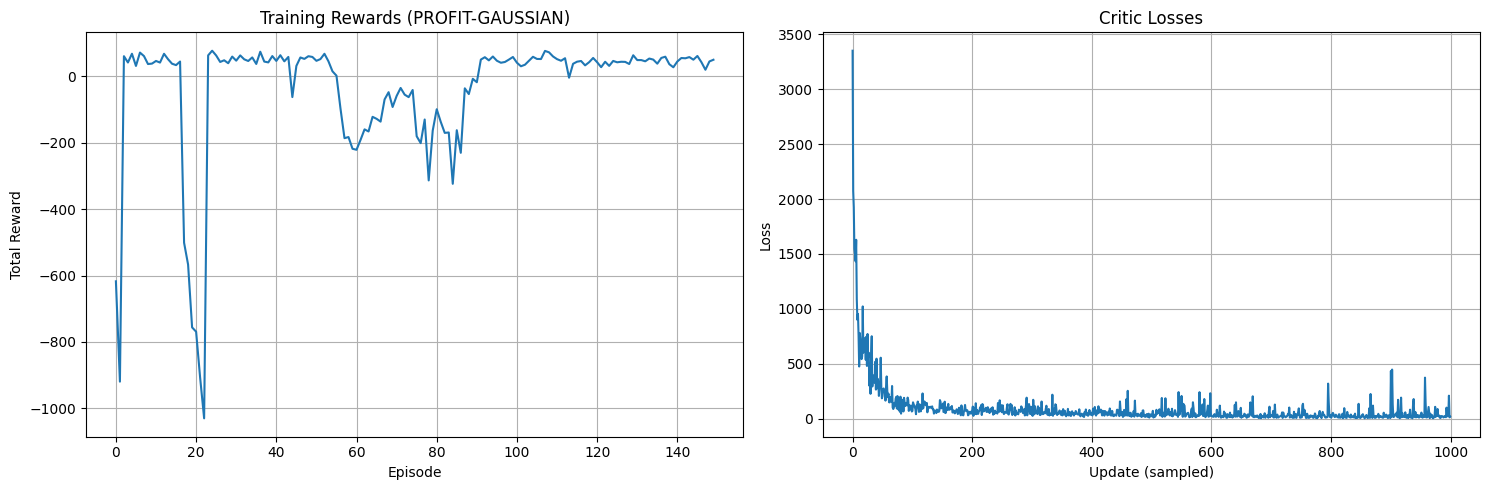


Running configuration: Reward=PROFIT, Demand=SINUSOIDAL
Episode 10/150 | Avg Reward (last 10): -2135.51
Episode 20/150 | Avg Reward (last 10): 51.60
Episode 30/150 | Avg Reward (last 10): -265.17
Episode 40/150 | Avg Reward (last 10): 42.96
Episode 50/150 | Avg Reward (last 10): 53.05
Episode 60/150 | Avg Reward (last 10): 50.14
Episode 70/150 | Avg Reward (last 10): 56.97
Episode 80/150 | Avg Reward (last 10): 53.39
Episode 90/150 | Avg Reward (last 10): 48.10
Episode 100/150 | Avg Reward (last 10): 41.64
Episode 110/150 | Avg Reward (last 10): 46.86
Episode 120/150 | Avg Reward (last 10): -160.67
Episode 130/150 | Avg Reward (last 10): 36.72
Episode 140/150 | Avg Reward (last 10): 37.55
Episode 150/150 | Avg Reward (last 10): 37.97
Training completed in 818.75 seconds
Performance : Avg reward = 24.87 ± 96.82
Evaluation: Avg reward = -22.17 ± 175.30


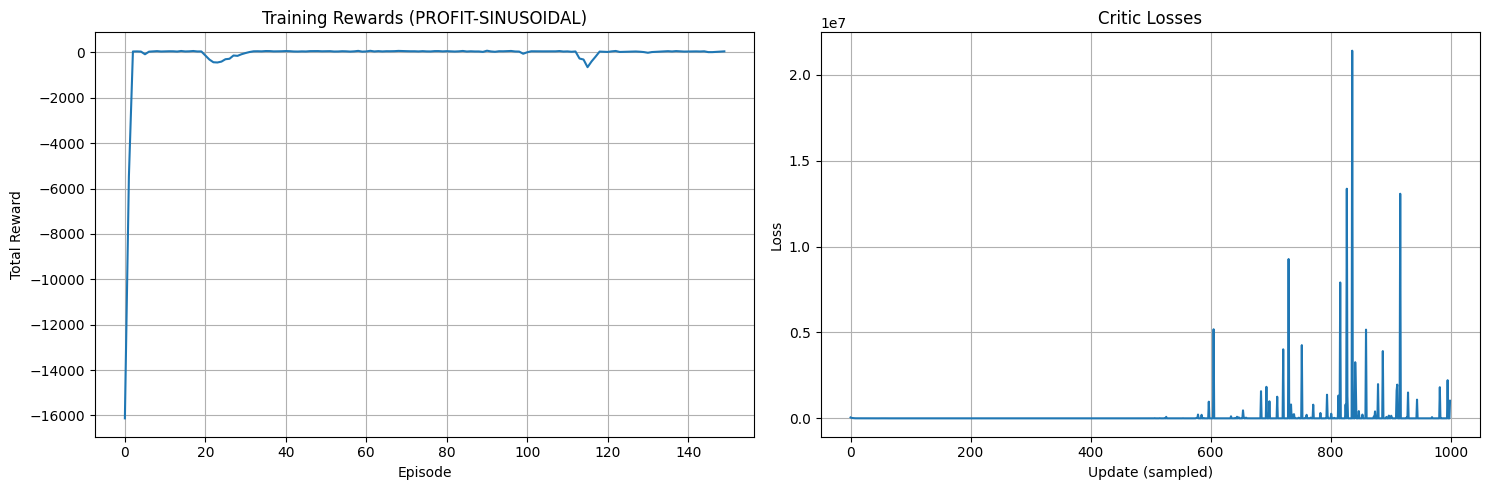


Running configuration: Reward=PROFIT, Demand=STEP
Episode 10/150 | Avg Reward (last 10): -1080.83
Episode 20/150 | Avg Reward (last 10): 52.01
Episode 30/150 | Avg Reward (last 10): -47.37
Episode 40/150 | Avg Reward (last 10): -214.97
Episode 50/150 | Avg Reward (last 10): -141.41
Episode 60/150 | Avg Reward (last 10): -153.24
Episode 70/150 | Avg Reward (last 10): -170.82
Episode 80/150 | Avg Reward (last 10): -151.93
Episode 90/150 | Avg Reward (last 10): -82.10
Episode 100/150 | Avg Reward (last 10): -40.21
Episode 110/150 | Avg Reward (last 10): 9.73
Episode 120/150 | Avg Reward (last 10): 52.31
Episode 130/150 | Avg Reward (last 10): 44.86
Episode 140/150 | Avg Reward (last 10): 49.30
Episode 150/150 | Avg Reward (last 10): 55.87
Training completed in 815.98 seconds
Performance : Avg reward = -38.62 ± 94.64
Evaluation: Avg reward = -6676.43 ± 5957.94


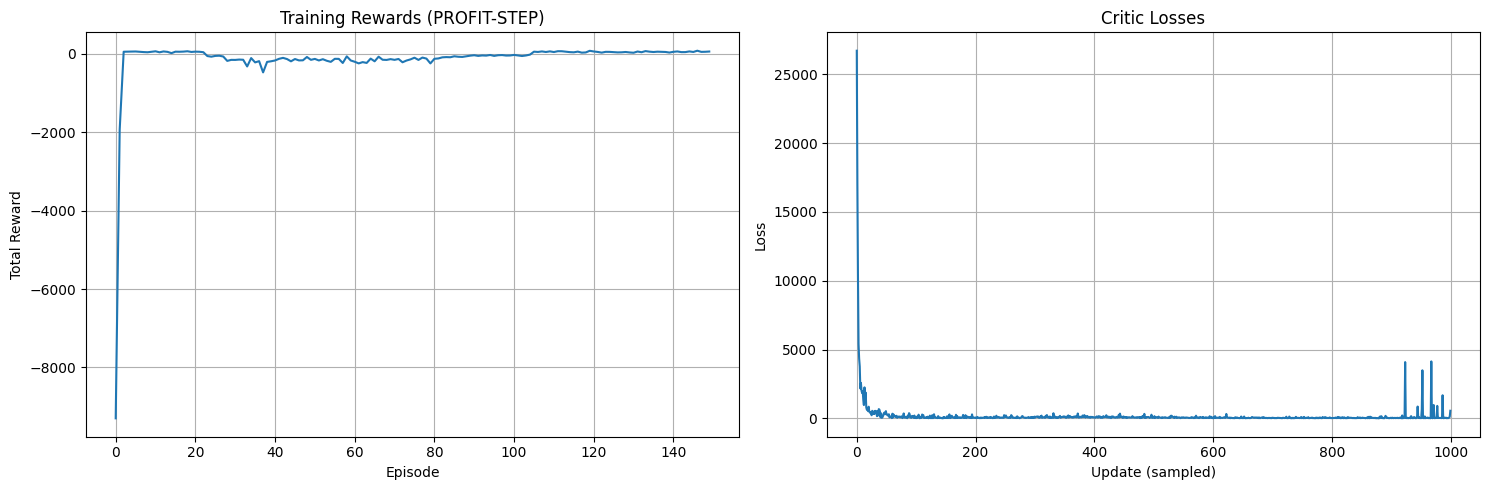


Running configuration: Reward=INTERNAL_DEMAND, Demand=GAUSSIAN
Episode 10/150 | Avg Reward (last 10): -4799.43
Episode 20/150 | Avg Reward (last 10): -3571.56
Episode 30/150 | Avg Reward (last 10): -2344.91
Episode 40/150 | Avg Reward (last 10): -1482.82
Episode 50/150 | Avg Reward (last 10): -503.89
Episode 60/150 | Avg Reward (last 10): -83.31
Episode 70/150 | Avg Reward (last 10): -48.72
Episode 80/150 | Avg Reward (last 10): -52.74
Episode 90/150 | Avg Reward (last 10): -51.68
Episode 100/150 | Avg Reward (last 10): -183.16
Episode 110/150 | Avg Reward (last 10): -139.90
Episode 120/150 | Avg Reward (last 10): -167.77
Episode 130/150 | Avg Reward (last 10): -416.72
Episode 140/150 | Avg Reward (last 10): -518.43
Episode 150/150 | Avg Reward (last 10): -568.97
Training completed in 817.05 seconds
Performance : Avg reward = -223.14 ± 261.03
Evaluation: Avg reward = -6994.39 ± 681.69


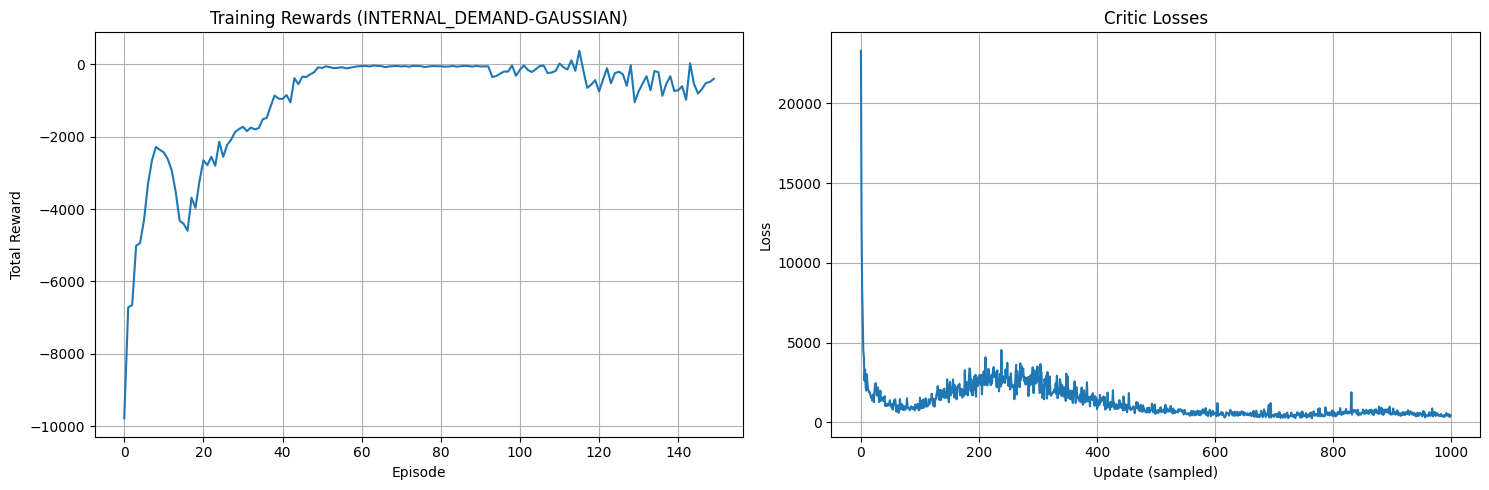


Comparative Results:
           Configuration     Reward Type Demand Type  Avg Reward   Std Reward   Avg Reward (Eval)  Std Reward (Eval)  Training Time (s)  Final Entropy
         PROFIT_GAUSSIAN          PROFIT    GAUSSIAN   -16.732492    97.658894        -914.916339         443.410694         817.031076       0.000584
       PROFIT_SINUSOIDAL          PROFIT  SINUSOIDAL    24.868587    96.818686         -22.167665         175.296143         818.752898       0.001256
             PROFIT_STEP          PROFIT        STEP   -38.623954    94.639554       -6676.429017        5957.939736         815.983376       0.004804
INTERNAL_DEMAND_GAUSSIAN INTERNAL_DEMAND    GAUSSIAN  -223.140210   261.032199       -6994.390862         681.689336         817.046561       0.300990


In [ ]:
base_hyperparams = {
    "battery_capacity": 100,
    "initial_soc": 50.0,
    "gamma": 0.99,
    "tau": 0.005,
    "alpha": 0.2,
    "automatic_entropy_tuning": True,
    "hidden_dim": 128,
    "actor_lr": 3e-4,
    "critic_lr": 3e-4,
    "alpha_lr": 3e-4,
    "replay_capacity": 100_000,
    "batch_size": 256,
    "num_episodes": 150,
    "max_steps_per_episode": 200
}

num_episodes = 150
eval_episodes = 3

print("Running SAC agents with selected configurations...")
results = {}
training_histories = {}

# Run profit reward with all demand types and
#  one additional configuration with INTERNAL_DEMAND
for demand_type in demand_types:
    config_name = f"{RewardType.PROFIT.value}_{demand_type.value}"
    results[config_name], training_histories[config_name] = run_configuration(
        RewardType.PROFIT, demand_type, num_episodes, eval_episodes
    )

config_name = f"{RewardType.INTERNAL_DEMAND.value}_{DemandType.GAUSSIAN.value}"
results[config_name], training_histories[config_name] = run_configuration(
    RewardType.INTERNAL_DEMAND, DemandType.GAUSSIAN, num_episodes, eval_episodes
)

results_df = pd.DataFrame([
    {
        'Configuration': f"{data['reward_type']}_{data['demand_type']}",
        'Reward Type': data['reward_type'],
        'Demand Type': data['demand_type'],
        'Avg Reward ': data['avg_reward_latter'],
        'Std Reward ': data['std_reward_latter'],
        'Avg Reward (Eval)': data['avg_reward_eval'],
        'Std Reward (Eval)': data['std_reward_eval'],
        'Training Time (s)': data['training_time'],
        'Final Entropy': data['final_entropy']
    }
    for config_name, data in results.items()
])

print("\nComparative Results:")
print(results_df.to_string(index=False))


Fixed Comparative Results:
           Configuration     Reward Type Demand Type  Avg Reward  Std Reward  Avg Reward (Eval)  Std Reward (Eval)  Training Time (s)  Final Entropy
         PROFIT_GAUSSIAN          PROFIT    GAUSSIAN  -16.732492   97.658894        -914.916339         443.410694         817.031076       0.000584
       PROFIT_SINUSOIDAL          PROFIT  SINUSOIDAL   24.868587   96.818686         -22.167665         175.296143         818.752898       0.001256
             PROFIT_STEP          PROFIT        STEP  -38.623954   94.639554       -6676.429017        5957.939736         815.983376       0.004804
INTERNAL_DEMAND_GAUSSIAN INTERNAL_DEMAND    GAUSSIAN -223.140210  261.032199       -6994.390862         681.689336         817.046561       0.300990


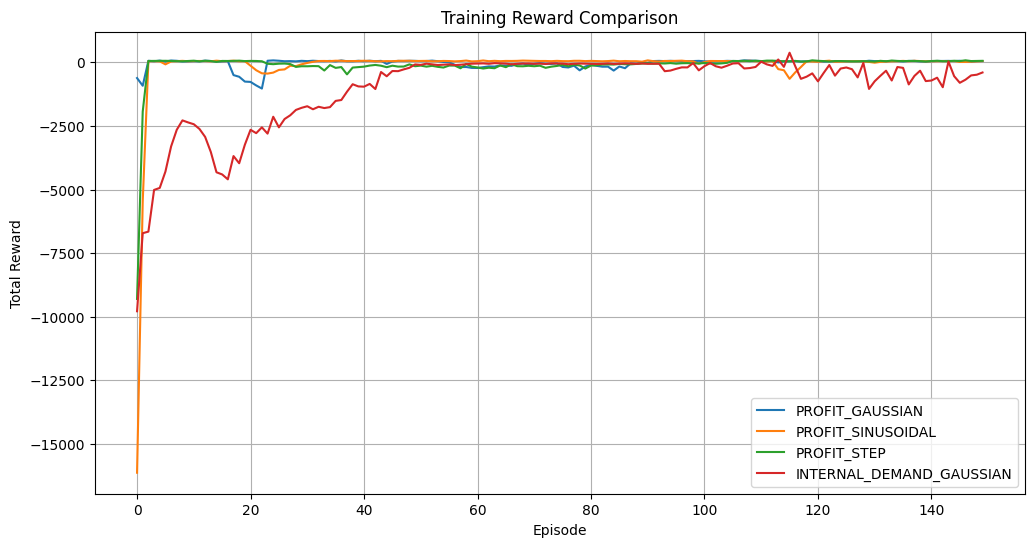

In [ ]:
results_df_fixed = results_df.rename(columns=lambda x: x.strip())

# Print the fixed DataFrame
print("\nFixed Comparative Results:")
print(results_df_fixed.to_string(index=False))

# Plot all training histories together
plt.figure(figsize=(12, 6))
for config_name, history in training_histories.items():
    plt.plot(history, label=config_name)

plt.title('Training Reward Comparison')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

# <img src="https://img.icons8.com/?size=100&id=121704&format=png&color=000000" style="height:50px;display:inline"> **Research a new Training Paradigm**

## **Lookahead Critic in Soft Actor-Critic (SAC) with TD(n)**
During our experimentation, we observed high variance in some training runs, which motivated us to explore strategies for stabilizing the learning process. One key takeaway from the course was that $TD(0)$ introduces minimal variance, making it a robust choice for learning updates. We extended the concept to the $TD(n)$, integrating it into our Soft Actor-Critic (SAC). This resulted in the development of our lookahead critic which improves the estimation of long-term rewards.

Unlike traditional one-step temporal difference updates, which may suffer from high variance and limited foresight, the lookahead critic enables the network to anticipate rewards over a longer horizon. The critic "looks 10 steps ahead," leading to a more stable Q-value estimation. More importantly, instead of simply providing local value approximations, the critic now serves as a "guiding mechanism" for the actor, promoting more informed action selection.

The lookahead critic computes the Q-value target using $TD(n)$:
$$
y_t = \sum_{k=0}^{n-1} \gamma^k r_{t+k} + \gamma^n \left[Q(s_{t+n}, a_{t+n}) - \alpha \log \pi(a_{t+n}|s_{t+n})\right]
$$
where the accumulated rewards over $n$ steps are combined with a bootstrapped Q-value at the $n$-th step.

By incorporating the lookahead critic, our agent should anticipate delayed rewards more accurately. This results in a more reliable Q-value estimation, which in turn guides the policy update more effectively

In [ ]:
class CriticAhead(Critic):
    """
    Extension of SAC Critic that uses TD(n) with n=10 for multi-step lookahead.
    Predicts future rewards by accumulating 10-step returns and bootstrapping
    from the value at the 10th step. Integrates with SACAgent as a drop-in replacement
    for the standard critic (same interface).
    """
    def __init__(self, *args, n_step: int = 10, **kwargs):
        super(CriticAhead, self).__init__(*args, **kwargs)  # initialize base Critic (networks, etc.)
        self.n_step = n_step  # number of lookahead steps (default 10)
        self.device = getattr(self, "device", torch.device("cpu"))

    def update(self, replay_buffer, actor, target_critic, alpha: float, gamma: float = 0.99, batch_size: int = 256):
        """
        Update the critic using TD(n) with n=10 step returns.
        Args:
            replay_buffer: Replay buffer from which to sample transitions.
            actor: The policy network (actor) to compute next actions and log-probs.
            target_critic: The target critic (with frozen parameters) for bootstrapping.
            alpha: Entropy temperature coefficient.
            gamma: Discount factor for rewards.
            batch_size: Number of samples to train on.
        """
        # Sample a batch of experiences from replay buffer.
        # We assume replay_buffer.sample can return indices for sequential lookup.
        states, actions, _, _, _, indices = replay_buffer.sample(batch_size, return_indices=True)
        # Convert states and actions to tensors (for current Q evaluation)
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.float32, device=self.device)

        # Initialize a tensor for target Q values (returns) for each sample in the batch
        batch_returns = torch.zeros((batch_size, 1), dtype=torch.float32, device=self.device)
        # Lists to gather states for bootstrapping and their discount factors
        bootstrap_states = []
        bootstrap_discounts = []
        bootstrap_indices = []  # indices of batch samples that will be bootstrapped

        # Compute multi-step returns for each sampled index
        for batch_idx, idx in enumerate(indices):
            G = 0.0        # cumulative return
            discount = 1.0  # discount factor for current step
            done_flag = False
            # Traverse up to n_step transitions starting from idx
            for n in range(self.n_step):
                # If we've run out of the buffer or hit a terminal state, stop
                if idx + n >= len(replay_buffer):
                    # Not enough future transitions (treat as terminal for return calculation)
                    done_flag = True
                    break
                reward_n = replay_buffer.rewards[idx + n]
                done_n   = replay_buffer.dones[idx + n]
                G += discount * reward_n  # add discounted reward
                if done_n:  # episode ended before reaching n steps
                    done_flag = True
                    break
                discount *= gamma  # accumulate discount
            batch_returns[batch_idx] = G  # store the partial return
            # If episode didn't end within n steps and we have an nth transition, bootstrap from that state
            if not done_flag:
                # State at (idx + n_step) for bootstrapping (i.e., s_{t+n})
                last_transition_index = idx + self.n_step - 1
                bootstrap_state = replay_buffer.next_states[last_transition_index]
                bootstrap_states.append(bootstrap_state)
                bootstrap_discounts.append(discount * gamma)  # discount already = gamma^(n-1) at loop end, multiply by gamma for gamma^n
                bootstrap_indices.append(batch_idx)

        # Compute bootstrapped value for each collected state using target critic and current policy (no grad)
        if len(bootstrap_states) > 0:
            bs_tensor = torch.tensor(bootstrap_states, dtype=torch.float32, device=self.device)
            with torch.no_grad():
                # Get action and log-probability from the actor for each bootstrap state
                action_bs, logp_bs = actor(bs_tensor)  # assume actor returns (action, log_prob) for given state batch
                # Compute target Q values from target critic (taking min of twin Qs)
                Q1_bs, Q2_bs = target_critic(bs_tensor, action_bs)  # target critic forward pass
                Q_min_bs = torch.min(Q1_bs, Q2_bs)
            # Add the discounted bootstrapped value to the returns
            for i, batch_idx in enumerate(bootstrap_indices):
                # y_i = accumulated reward + gamma^n * [Q_target(s_{t+n}, a_{t+n}) - alpha * logπ(a_{t+n}|s_{t+n})]
                batch_returns[batch_idx] += bootstrap_discounts[i] * (Q_min_bs[i] - alpha * logp_bs[i])

        # Critic loss: Mean squared error between current Q estimates and the multi-step return targets
        # Get current Q estimates from the two Q-networks for the sampled states and actions
        Q1_pred, Q2_pred = self(states, actions)  # forward pass of twin Q networks (CriticAhead inherits Critic's forward)
        # Compute MSE loss for each Q function
        loss_Q1 = F.mse_loss(Q1_pred, batch_returns)
        loss_Q2 = F.mse_loss(Q2_pred, batch_returns)
        critic_loss = loss_Q1 + loss_Q2

        # Optimize the critic (assuming CriticAhead has an optimizer for Q networks)
        self.optimizer.zero_grad()
        critic_loss.backward()
        self.optimizer.step()

        return critic_loss.item()



## utilities for CrticAhead

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SACAgentAhead(SACAgent):
    def __init__(self, hyperparams):
        """
        Initialize the Soft Actor-Critic agent with n-step lookahead critic.

        Args:
            hyperparams (dict): Dictionary containing hyperparameters
        """
        # Initialize base SACAgent properties
        super(SACAgentAhead, self).__init__(hyperparams)

        # Override critics with CriticAhead
        n_step = hyperparams.get("n_step", 10)  # Get n_step from hyperparams or default to 10

        # Replace the critics with CriticAhead
        self.critic_1 = CriticAhead(self.state_dim, self.action_dim, self.hidden_dim, n_step=n_step).to(device)
        self.critic_2 = CriticAhead(self.state_dim, self.action_dim, self.hidden_dim, n_step=n_step).to(device)
        self.critic_1_target = CriticAhead(self.state_dim, self.action_dim, self.hidden_dim, n_step=n_step).to(device)
        self.critic_2_target = CriticAhead(self.state_dim, self.action_dim, self.hidden_dim, n_step=n_step).to(device)

        # Initialize target networks with same weights
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())

        # Optimizers for the critics
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=self.critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=self.critic_lr)

        # For logging
        self.writer = SummaryWriter(f"runs/sac_ahead_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

class EnhancedReplayBuffer(ReplayBuffer):
    def __init__(self, capacity):
        super(EnhancedReplayBuffer, self).__init__(capacity)
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []

    def add(self, state, action, reward, next_state, done):
        """Add a new transition to the buffer"""
        if len(self.buffer) < self.capacity:
            self.states.append(state)
            self.actions.append(action)
            self.rewards.append(reward)
            self.next_states.append(next_state)
            self.dones.append(done)
            self.buffer.append(None)
        else:
            idx = self.position
            self.states[idx] = state
            self.actions[idx] = action
            self.rewards[idx] = reward
            self.next_states[idx] = next_state
            self.dones[idx] = done

        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, return_indices=False):
        """Sample a batch of transitions and optionally return indices"""
        indices = np.random.randint(0, len(self.buffer), size=batch_size)

        states = np.array([self.states[i] for i in indices])
        actions = np.array([self.actions[i] for i in indices])
        rewards = np.array([self.rewards[i] for i in indices])
        next_states = np.array([self.next_states[i] for i in indices])
        dones = np.array([self.dones[i] for i in indices])

        if return_indices:
            return states, actions, rewards, next_states, dones, indices
        return states, actions, rewards, next_states, dones

# Helper function to train an agent
def train_agent(agent, env, num_episodes):
    """Train an agent in the given environment and return episode rewards"""
    episode_rewards = []

    start_time = time.time()
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        truncated = False

        # Episode loop
        while not (done or truncated):
            # Select action
            action = agent.select_action(state)
            action = np.array([action], dtype=np.float32)

            # Execute action
            next_state, reward, done, truncated, _ = env.step(action)

            # Store transition
            agent.store_transition(state, action[0], reward, next_state, done or truncated)

            # Multiple updates per step
            if len(agent.replay_buffer) >= agent.batch_size:
                for _ in range(agent.updates_per_step):
                    critic_loss, actor_loss, alpha_loss = agent.update_parameters()

            # Update state and reward
            state = next_state
            episode_reward += reward

        # Track episode reward
        episode_rewards.append(episode_reward)

        # Status update every 10 episodes
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode+1}/{num_episodes} | Avg Reward (last 10): {avg_reward:.2f}")

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    return episode_rewards

# Helper function to evaluate an agent
def evaluate_agent(agent, env, n_episodes):
    """Evaluate an agent in the given environment and return rewards"""
    eval_rewards = []

    for i in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            # Select action (deterministic policy for evaluation)
            action = agent.select_action(state, evaluate=True)
            action = np.array([action], dtype=np.float32)

            # Execute action
            next_state, reward, done, truncated, _ = env.step(action)

            # Update state and reward
            state = next_state
            episode_reward += reward

        eval_rewards.append(episode_reward)

    avg_reward = np.mean(eval_rewards)
    std_reward = np.std(eval_rewards)
    print(f"Evaluation: Avg reward = {avg_reward:.2f} ± {std_reward:.2f}")

    return eval_rewards

# Function to compare standard SAC with n-step SAC for a specific config
def compare_profit_gaussian_agents(num_episodes=300, eval_episodes=5):
    """
    Compare standard SAC agent with n-step lookahead version for PROFIT reward and GAUSSIAN demand.

    Args:
        num_episodes: Number of episodes to train for
        eval_episodes: Number of episodes to evaluate on

    Returns:
        Comparison results and training histories
    """
    print("\nComparing agents with PROFIT reward and GAUSSIAN demand")

    # Set up hyperparameters
    hyperparams = base_hyperparams.copy()
    hyperparams["reward type"] = RewardType.PROFIT
    hyperparams["demand type"] = DemandType.GAUSSIAN
    hyperparams["updates_per_step"] = 2

    # Create environments for both agents
    env_standard = gym.make('ElectricityMarketEnv-v0', params=hyperparams)
    env_ahead = gym.make('ElectricityMarketEnv-v0', params=hyperparams)

    # Wrap the environments with the normalizer
    normalized_env_standard = NormalizedEnv(env_standard)
    normalized_env_ahead = NormalizedEnv(env_ahead)

    # Update hyperparams with environment-specific info
    hyperparams["state_dim"] = env_standard.observation_space.shape[0]
    hyperparams["battery_capacity"] = env_standard.unwrapped.battery_capacity
    hyperparams["max_steps_per_episode"] = env_standard.unwrapped.max_steps

    # Add n_step parameter for ahead agent
    hyperparams_ahead = hyperparams.copy()
    hyperparams_ahead["n_step"] = 10

    # Create agents
    standard_agent = SACAgent(hyperparams)
    ahead_agent = SACAgentAhead(hyperparams_ahead)

    # Training metrics
    results = {}
    training_histories = {}

    # Train standard agent
    print("\nTraining standard SAC agent...")
    standard_rewards = train_agent(standard_agent, normalized_env_standard, num_episodes)
    training_histories["standard_sac"] = standard_rewards

    # Train ahead agent
    print("\nTraining SAC agent with n-step lookahead...")
    ahead_rewards = train_agent(ahead_agent, normalized_env_ahead, num_episodes)
    training_histories["ahead_sac"] = ahead_rewards

    # Evaluate standard agent
    print("\nEvaluating standard SAC agent...")
    standard_eval_rewards = evaluate_agent(standard_agent, env_standard, eval_episodes)

    # Evaluate ahead agent
    print("\nEvaluating SAC agent with n-step lookahead...")
    ahead_eval_rewards = evaluate_agent(ahead_agent, env_ahead, eval_episodes)

    # Calculate metrics
    avg_reward_standard = np.mean(standard_rewards[50:])
    std_reward_standard = np.std(standard_rewards[50:])
    avg_eval_standard = np.mean(standard_eval_rewards)
    std_eval_standard = np.std(standard_eval_rewards)

    avg_reward_ahead = np.mean(ahead_rewards[50:])
    std_reward_ahead = np.std(ahead_rewards[50:])
    avg_eval_ahead = np.mean(ahead_eval_rewards)
    std_eval_ahead = np.std(ahead_eval_rewards)

    # Store results
    results["standard_sac"] = {
        'agent': 'Standard SAC',
        'avg_reward_latter': avg_reward_standard,
        'std_reward_latter': std_reward_standard,
        'avg_reward_eval': avg_eval_standard,
        'std_reward_eval': std_eval_standard,
        'agent_instance': standard_agent
    }

    results["ahead_sac"] = {
        'agent': 'SAC with n-step',
        'avg_reward_latter': avg_reward_ahead,
        'std_reward_latter': std_reward_ahead,
        'avg_reward_eval': avg_eval_ahead,
        'std_reward_eval': std_eval_ahead,
        'agent_instance': ahead_agent
    }

    # Print improvement percentage
    improvement = (avg_eval_ahead - avg_eval_standard) / abs(avg_eval_standard) * 100
    print(f"\nPerformance improvement with n-step lookahead: {improvement:.2f}%")

    return results, training_histories

# <img src="https://img.icons8.com/?size=100&id=122512&format=png&color=000000" style="height:50px;display:inline"> Results and Plots

Running comparison between standard SAC and SAC with CriticAhead...

Comparing agents with PROFIT reward and GAUSSIAN demand

Training standard SAC agent...
Episode 10/150 | Avg Reward (last 10): -820.04
Episode 20/150 | Avg Reward (last 10): 41.71
Episode 30/150 | Avg Reward (last 10): -224.41
Episode 40/150 | Avg Reward (last 10): -443.47
Episode 50/150 | Avg Reward (last 10): -93.84
Episode 60/150 | Avg Reward (last 10): -58.08
Episode 70/150 | Avg Reward (last 10): -55.98
Episode 80/150 | Avg Reward (last 10): -57.18
Episode 90/150 | Avg Reward (last 10): -45.38
Episode 100/150 | Avg Reward (last 10): -45.00
Episode 110/150 | Avg Reward (last 10): -381.64
Episode 120/150 | Avg Reward (last 10): -57.45
Episode 130/150 | Avg Reward (last 10): 0.67
Episode 140/150 | Avg Reward (last 10): 2.53
Episode 150/150 | Avg Reward (last 10): 0.25
Training completed in 813.85 seconds

Training SAC agent with n-step lookahead...
Episode 10/150 | Avg Reward (last 10): -666.80
Episode 20/150 | Avg 

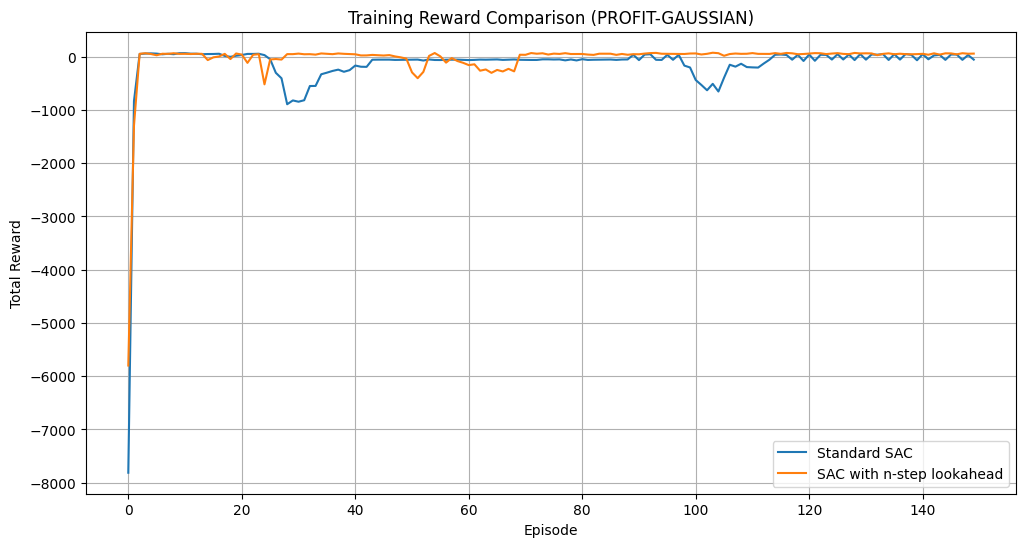


Comparison Results:
             Agent  Avg Reward (Eps 50+)  Std Reward (Eps 50+)  \
0     Standard SAC            -69.727698            131.936480   
1  SAC with n-step             10.563807            106.514852   

   Avg Reward (Eval)  Std Reward (Eval)  
0        -955.442219         170.300292  
1         556.124964          42.690361  


In [ ]:
base_hyperparams = {
    "battery_capacity": 100,
    "initial_soc": 50.0,
    "gamma": 0.99,
    "tau": 0.005,
    "alpha": 0.2,
    "automatic_entropy_tuning": True,
    "hidden_dim": 128,
    "actor_lr": 3e-4,
    "critic_lr": 3e-4,
    "alpha_lr": 3e-4,
    "replay_capacity": 100_000,
    "batch_size": 256,
    "num_episodes": 150,
    "max_steps_per_episode": 200,
    "n_step": 10  # Default n-step value
}

num_episodes = 150
eval_episodes = 5

# Run comparison for PROFIT-GAUSSIAN only
print("Running comparison between standard SAC and SAC with CriticAhead...")
results, training_histories = compare_profit_gaussian_agents(num_episodes, eval_episodes)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(training_histories["standard_sac"], label='Standard SAC')
plt.plot(training_histories["ahead_sac"], label='SAC with n-step lookahead')
plt.title('Training Reward Comparison (PROFIT-GAUSSIAN)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame([
    {
        'Agent': results[agent_name]['agent'],
        'Avg Reward (Eps 50+)': results[agent_name]['avg_reward_latter'],
        'Std Reward (Eps 50+)': results[agent_name]['std_reward_latter'],
        'Avg Reward (Eval)': results[agent_name]['avg_reward_eval'],
        'Std Reward (Eval)': results[agent_name]['std_reward_eval'],
    }
    for agent_name in ['standard_sac', 'ahead_sac']
])

print("\nComparison Results:")
print(results_df)

# Save the agents
standard_agent = results["standard_sac"]["agent_instance"]
ahead_agent = results["ahead_sac"]["agent_instance"]

standard_agent.save("standard_sac_agent.pt")
ahead_agent.save("ahead_sac_agent.pt")

Running comparison between standard SAC and SAC with CriticAhead for SINUSOIDAL demand...

Comparing agents with PROFIT reward and SINUSOIDAL demand

Training standard SAC agent...
Episode 10/150 | Avg Reward (last 10): -53.14
Episode 20/150 | Avg Reward (last 10): 53.95
Episode 30/150 | Avg Reward (last 10): 39.96
Episode 40/150 | Avg Reward (last 10): -30.64
Episode 50/150 | Avg Reward (last 10): 37.05
Episode 60/150 | Avg Reward (last 10): 35.88
Episode 70/150 | Avg Reward (last 10): 42.64
Episode 80/150 | Avg Reward (last 10): 24.93
Episode 90/150 | Avg Reward (last 10): 36.90
Episode 100/150 | Avg Reward (last 10): 42.33
Episode 110/150 | Avg Reward (last 10): -7.30
Episode 120/150 | Avg Reward (last 10): -126.93
Episode 130/150 | Avg Reward (last 10): 51.69
Episode 140/150 | Avg Reward (last 10): 49.37
Episode 150/150 | Avg Reward (last 10): 53.00
Training completed in 819.27 seconds

Training SAC agent with n-step lookahead...
Episode 10/150 | Avg Reward (last 10): -762.71
Episo

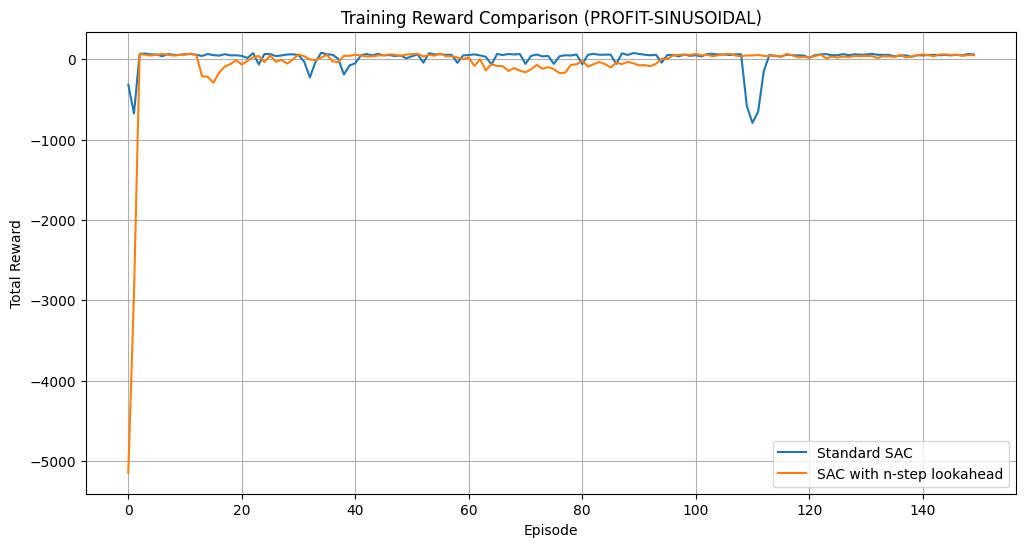


Comparison Results for SINUSOIDAL Demand:
             Agent  Avg Reward (Eps 50+)  Std Reward (Eps 50+)  \
0     Standard SAC             20.250673            128.490936   
1  SAC with n-step             -1.026224             66.719927   

   Avg Reward (Eval)  Std Reward (Eval)  
0         521.230944         118.539626  
1         562.418743         103.411362  


In [ ]:
# Function to compare standard SAC with n-step SAC for PROFIT reward and SINUSOIDAL demand
def compare_profit_sinusoidal_agents(num_episodes=150, eval_episodes=5):
    """
    Compare standard SAC agent with n-step lookahead version for PROFIT reward and SINUSOIDAL demand.

    Args:
        num_episodes: Number of episodes to train for
        eval_episodes: Number of episodes to evaluate on

    Returns:
        Comparison results and training histories
    """
    print("\nComparing agents with PROFIT reward and SINUSOIDAL demand")

    # Set up hyperparameters
    hyperparams = base_hyperparams.copy()
    hyperparams["reward type"] = RewardType.PROFIT
    hyperparams["demand type"] = DemandType.SINUSOIDAL
    hyperparams["updates_per_step"] = 2

    # Create environments for both agents
    env_standard = gym.make('ElectricityMarketEnv-v0', params=hyperparams)
    env_ahead = gym.make('ElectricityMarketEnv-v0', params=hyperparams)

    # Wrap the environments with the normalizer
    normalized_env_standard = NormalizedEnv(env_standard)
    normalized_env_ahead = NormalizedEnv(env_ahead)

    # Update hyperparams with environment-specific info
    hyperparams["state_dim"] = env_standard.observation_space.shape[0]
    hyperparams["battery_capacity"] = env_standard.unwrapped.battery_capacity
    hyperparams["max_steps_per_episode"] = env_standard.unwrapped.max_steps

    # Add n_step parameter for ahead agent
    hyperparams_ahead = hyperparams.copy()
    hyperparams_ahead["n_step"] = 10

    # Create agents
    standard_agent = SACAgent(hyperparams)
    ahead_agent = SACAgentAhead(hyperparams_ahead)

    # Training metrics
    results = {}
    training_histories = {}

    # Train standard agent
    print("\nTraining standard SAC agent...")
    standard_rewards = train_agent(standard_agent, normalized_env_standard, num_episodes)
    training_histories["standard_sac"] = standard_rewards

    # Train ahead agent
    print("\nTraining SAC agent with n-step lookahead...")
    ahead_rewards = train_agent(ahead_agent, normalized_env_ahead, num_episodes)
    training_histories["ahead_sac"] = ahead_rewards

    # Evaluate standard agent
    print("\nEvaluating standard SAC agent...")
    standard_eval_rewards = evaluate_agent(standard_agent, env_standard, eval_episodes)

    # Evaluate ahead agent
    print("\nEvaluating SAC agent with n-step lookahead...")
    ahead_eval_rewards = evaluate_agent(ahead_agent, env_ahead, eval_episodes)

    # Calculate metrics
    avg_reward_standard = np.mean(standard_rewards[50:])
    std_reward_standard = np.std(standard_rewards[50:])
    avg_eval_standard = np.mean(standard_eval_rewards)
    std_eval_standard = np.std(standard_eval_rewards)

    avg_reward_ahead = np.mean(ahead_rewards[50:])
    std_reward_ahead = np.std(ahead_rewards[50:])
    avg_eval_ahead = np.mean(ahead_eval_rewards)
    std_eval_ahead = np.std(ahead_eval_rewards)

    # Store results
    results["standard_sac"] = {
        'agent': 'Standard SAC',
        'avg_reward_latter': avg_reward_standard,
        'std_reward_latter': std_reward_standard,
        'avg_reward_eval': avg_eval_standard,
        'std_reward_eval': std_eval_standard,
        'agent_instance': standard_agent
    }

    results["ahead_sac"] = {
        'agent': 'SAC with n-step',
        'avg_reward_latter': avg_reward_ahead,
        'std_reward_latter': std_reward_ahead,
        'avg_reward_eval': avg_eval_ahead,
        'std_reward_eval': std_eval_ahead,
        'agent_instance': ahead_agent
    }

    # Print improvement percentage
    improvement = (avg_eval_ahead - avg_eval_standard) / abs(avg_eval_standard) * 100
    print(f"\nPerformance improvement with n-step lookahead: {improvement:.2f}%")

    return results, training_histories

# Run comparison for PROFIT-SINUSOIDAL
print("Running comparison between standard SAC and SAC with CriticAhead for SINUSOIDAL demand...")
sinusoidal_results, sinusoidal_training_histories = compare_profit_sinusoidal_agents(num_episodes, eval_episodes)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(sinusoidal_training_histories["standard_sac"], label='Standard SAC')
plt.plot(sinusoidal_training_histories["ahead_sac"], label='SAC with n-step lookahead')
plt.title('Training Reward Comparison (PROFIT-SINUSOIDAL)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

sinusoidal_results_df = pd.DataFrame([
    {
        'Agent': sinusoidal_results[agent_name]['agent'],
        'Avg Reward (Eps 50+)': sinusoidal_results[agent_name]['avg_reward_latter'],
        'Std Reward (Eps 50+)': sinusoidal_results[agent_name]['std_reward_latter'],
        'Avg Reward (Eval)': sinusoidal_results[agent_name]['avg_reward_eval'],
        'Std Reward (Eval)': sinusoidal_results[agent_name]['std_reward_eval'],
    }
    for agent_name in ['standard_sac', 'ahead_sac']
])

print("\nComparison Results for SINUSOIDAL Demand:")
print(sinusoidal_results_df)

# Save the agents
sinusoidal_standard_agent = sinusoidal_results["standard_sac"]["agent_instance"]
sinusoidal_ahead_agent = sinusoidal_results["ahead_sac"]["agent_instance"]

sinusoidal_standard_agent.save("sinusoidal_standard_sac_agent.pt")
sinusoidal_ahead_agent.save("sinusoidal_ahead_sac_agent.pt")